# Deliberation

In [25]:
import numpy as np
import random
import math
from scipy.stats import beta
import networkx as nx
import pandas as pd

from mesa import Model, Agent
from mesa.space import NetworkGrid
from mesa.time import RandomActivation

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import mpmath 
from mpmath import mp
mp.prec = 100
sns.set()
from tqdm.notebook import tqdm
from itertools import starmap
from multiprocess import Pool, cpu_count

matplotlib.rcParams['figure.figsize'] = (9, 6)


## Evaluation Group Decision Methods

There are three types of criteria that can be used to  evaluate a proposed decision-making procedure: 

1. Practical reasons: The procedure should be easy to underst, eaasy to implement for groups of a given size, and following the procedure should not take too much time to arrive at a decision. 
2. Procedural reasons: The procedure should  should be fair and it should end up in a consensus that all group members endorse. 
3. Epistemic reasons: The group decision should be reliable and it should coincide with the fact of the matter if it is the task of the group to decide on a fact of the matter (e.g. the group decision should be 'guilty' if and only if the defendant is guilty).

No single procedure does best on all three criteria. 
We study the Bayesian model of deliberation from: 

S. Hartmann and S. Rafiee Rad (2018). [Voting, deliberation and truth](https://link.springer.com/content/pdf/10.1007%2Fs11229-016-1268-9.pdf), Synthese, 105, pp. 1273 - 1293. 

A formal analysis which (i) shows that deliberation procedures are truth-conducive (in a similar way as majority voting is truth conducive according to the Condorcet Jury Theorem) and that (ii) explores which procedure does better (under certain conditions) epistemically.




Fix a binary propositional variable with values $H$: the hypothesis is true, and $\neg H$: the hypothesis is false.  Assume that $H$ is true. 

Consider  a group of $n$ agents who deliberate on the truth or falsity of $H$. 

The group members express their individual verdicts in terms of a yes/no vote. The votes are represented by binary propositional variables $V_i$ (for $i = 1,\ldots, n$) with the values: $V_i$: agent $i$ votes "yes", i.e., that $H$ is true $\neg V_i$: agent $i$ votes "no", i.e., that $H$ is false. thesis is false.


1. During the procedure, no new evidence comes up. However, some people forgot or did not notice certain pieces of evidence. There is also disagreement about the strength of certain pieces of evidence. Initially, the jury members do not know each other at all (they were randomly assembled).  However, during the course of deliberation they get to know each other much better. They see how the others argue, how they criticize the arguments of others, and what they remember of the details of the case. This helps them to better assess how reliable the other group members are and which weight to assign to their verdicts.


2. Assume that it is in the interest of each group member that the probability that the ﬁnal verdict of the group corresponds to the truth is as large as possible.

3. Each group member $i$ has a first-order reliability $r_i$: the probability that $i$ will make the correct judgements. 

4. The other group members do not know the reliability of the other agents, but they can estimate it:  At stage $t$, 
$$r_{ij}^t = Pr^t_i(V_j\mid H) = Pr^t_i(\neg V_j\mid \neg H)$$
is $i$'s estimation of $j$'s first-order reliability. 

For each group member $i$, let $c_i$ be the second-order reliability of $i$ to judge the first-order reliability of the other group members.  So, if $c_i = 1$, then $i$ assigns correct first-order reliability to every group member $j$; and if $c_i = 0$, then $i$ assigns a random first-order reliability to the other agents drawn uniformaly from $(0,1)$.

To estimate a first-order reliability $r_j$, with second order reliability $c_i$, draw from a beta distribution with 

$$a=2\qquad b= \frac{\min(1, r_j - c_i + 1) - \max(0, r_j + c_i - 1)}{r_j - \max(0, r_j + c_i -1)}$$

in which $[0,1]$ is linearly transfered to the interval $[\max(0, r_j + c_i - 1), \min(1, r_j - c_i -1)]$

In [159]:
def find_beta(r, c):
    return 2, (min(1, r - c + 1) - max(0, r + c - 1)) / (r - max(0, r + c - 1))

def linear_transform(x, r, c): 
    max_x = min(1, r - c + 1)
    min_x = max(0, r + c - 1)
    return (max_x - min_x)* x + min_x

xs = np.linspace(0,1,100)

In [160]:
def estimate_reliability(rel, second_order_rel): 
    
    if second_order_rel == 0: 
        return np.random.uniform(0,1)
    elif second_order_rel == 1:
        return rel
    else: 
        return linear_transform(np.random.beta(*find_beta(rel, second_order_rel)), rel, second_order_rel)


    r_j - c_i, r_j + c_i

A second way of estimating that is a bit easier is to draw uniformly from the interval  $[\max(0, r_j + c_i - 1), \min(1, r_j - c_i -1)]$. 

In [161]:
def estimate_reliability2(rel, second_order_rel): 
    
    return np.random.uniform(max(0, rel + second_order_rel -1), min(1, rel - second_order_rel + 1))


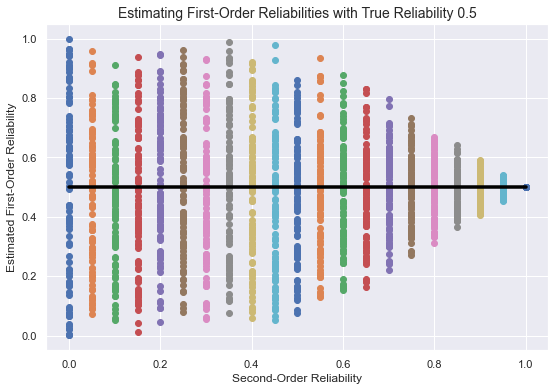

In [162]:
xs = np.linspace(0,1,1000)

rel = 0.5
for c in cs: 
    est_rels = [estimate_reliability(rel, c) for _ in range(100)]

    plt.scatter([c]*100, est_rels)
plt.ylabel("Estimated First-Order Reliability")
plt.xlabel("Second-Order Reliability")

plt.title(f"Estimating First-Order Reliabilities with True Reliability {rel}", fontsize=14)
plt.plot([0,1.0],[rel, rel],  '-', color="black",lw = 3.5);

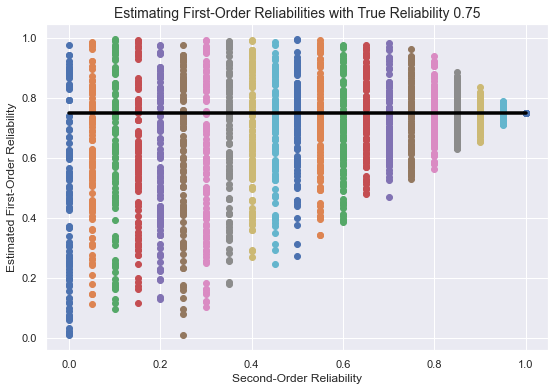

In [60]:
xs = np.linspace(0,1,1000)

rel = 0.75
for c in cs: 
    est_rels = [estimate_reliability(rel, c) for _ in range(100)]

    plt.scatter([c]*100, est_rels)
plt.ylabel("Estimated First-Order Reliability")
plt.xlabel("Second-Order Reliability")

plt.title(f"Estimating First-Order Reliabilities with True Reliability {rel}", fontsize=14)
plt.plot([0,1.0],[rel, rel],  '-', color="black",lw = 3.5);

Text(0.5, 1.0, 'Estimating (version 2) First-Order Reliabilities with True Reliability 0.5')

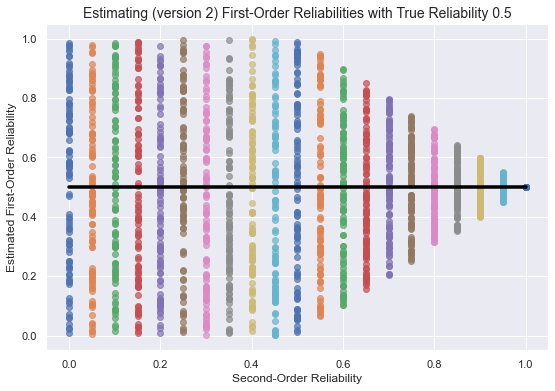

In [61]:
xs = np.linspace(0,1,1000)

rel = 0.5

for c in cs: 
    est_rels = [estimate_reliability2(rel, c) for _ in range(100)]

    plt.scatter([c]*100, est_rels, alpha=0.7)

plt.plot([0,1.0],[rel, rel],  '-', color="black",lw = 3.5)
plt.ylabel("Estimated First-Order Reliability")
plt.xlabel("Second-Order Reliability")
plt.title(f"Estimating (version 2) First-Order Reliabilities with True Reliability {rel}", fontsize=14)


Text(0.5, 1.0, 'Estimating (version 2) First-Order Reliabilities with True Reliability 0.75')

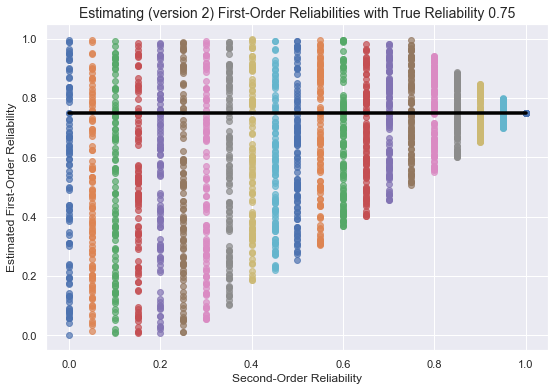

In [62]:
xs = np.linspace(0,1,1000)

rel = 0.75

for c in cs: 
    est_rels = [estimate_reliability2(rel, c) for _ in range(100)]

    plt.scatter([c]*100, est_rels, alpha=0.7)

plt.plot([0,1.0],[rel, rel],  '-', color="black",lw = 3.5)
plt.ylabel("Estimated First-Order Reliability")
plt.xlabel("Second-Order Reliability")
plt.title(f"Estimating (version 2) First-Order Reliabilities with True Reliability {rel}", fontsize=14)


5. The agents  become better and better in assessing the reliability of the other group members.   The 2nd-order reliability $c_i^k$ is round $k$ increases linearly as a function of the number of rounds until a maximum value of $C_i\le 1$ is reached after $M$ rounds.   Afterwards, the 2nd-order reliability is constant: 

Let $c_i^0$ be the initial 2nd-order reliability, $C_i$ the maximum reliability for $i$ and $M$ is the maximum number of rounds: 

$$c_i^k = \begin{cases} (C_i - c_i^0) \cdot k/M + c_i^0 & 0\le k\le M\\
C_i & k>M\end{cases}$$


In [164]:
def updated_second_order_reliability(int_rel2, round_num, max_rel2, max_num_rounds):
    
    return (((max_rel2 - int_rel2) * round_num / max_num_rounds) + int_rel2) if round_num <= max_num_rounds else max_rel2
    

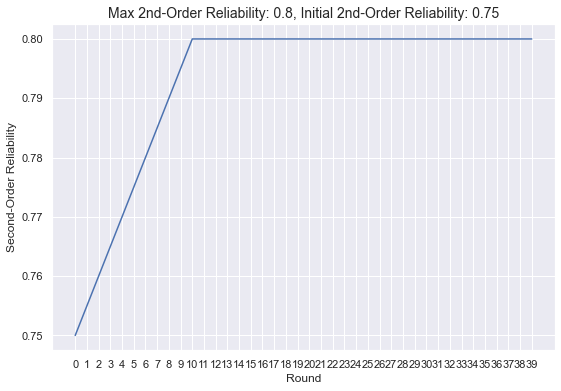

In [163]:
num_rounds = 40

max_num_rounds = 10
init_rel2 = 0.75
max_rel2 = 0.8

plt.plot([str(r) for r in range(num_rounds)], 
         [updated_second_order_reliability(init_rel2, r, max_rel2, max_num_rounds) for r in range(num_rounds)]);

plt.xlabel("Round")
plt.ylabel("Second-Order Reliability")
plt.title(f"Max 2nd-Order Reliability: {max_rel2}, Initial 2nd-Order Reliability: {init_rel2}", fontsize=14)
plt.show()

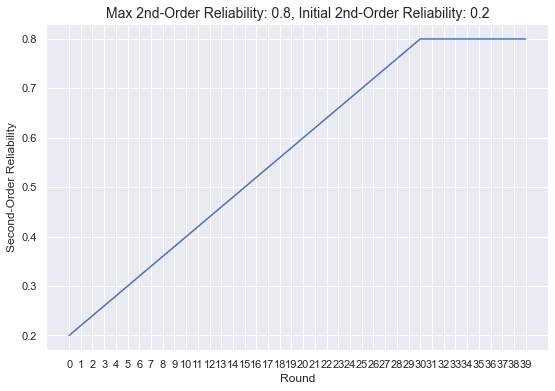

In [165]:
num_rounds = 40

max_num_rounds = 30
init_rel2 = 0.2
max_rel2 = 0.8

plt.plot([str(r) for r in range(num_rounds)], 
         [updated_second_order_reliability(init_rel2, r, max_rel2, max_num_rounds) for r in range(num_rounds)]);

plt.xlabel("Round")
plt.ylabel("Second-Order Reliability")
plt.title(f"Max 2nd-Order Reliability: {max_rel2}, Initial 2nd-Order Reliability: {init_rel2}", fontsize=14)
plt.show()

6. Using the reliability estimates,  each group member $i$ calculates the likelihood ratios at time $t$: 
$$x_{ij}^t = \frac{1-r_{ij}^t}{r_{ij}^t}$$
Then, $i$ updates $Pr_i^t$ as follows: 

$$Pr_i^{t+1}(H) = Pr_i^t(H\mid V_1^t, \ldots, V_{i-1}^t, V_{i+1}^t, \ldots, V_n^{t})$$
 $$= \frac{Pr_i^t(H)}{Pr_i^t(H) + (1-Pr_i^t(H))\Pi_{k\ne i}(x^t_{ik})^{p_k}}$$
 where $p_k = 1$ if $V_k$ and $p_k=-1$ otherwise.


To illustrate the above equation, let $\vec{V} = (1,0, 1, 1)$

$P_3^k(V_1\mid H) = r^k_{31}$

$P_3^k(V_2\mid H) = (1-r^k_{32})$

$P_3^k(V_4\mid H) = r^k_{34}$

$P_3^k(V_1\mid \neg H) = (1 - r^k_{31})$

$P_3^k(V_2\mid \neg H) = r^k_{32}$

$P_3^k(V_4\mid \neg H) = (1 - r^k_{34})$

$P_3^{k+1}(H) = P^{k}_3(H\mid V_1,V_2,V_3,V_4) = P_3^k(V_1, V_2,V_4\mid H)\frac{P_3^k(H)}{P_3^k(V_1,V_2,V_3)}$

$= P_3^k(V_1, V_2,V_4\mid H)\frac{P_3^k(H)}{P_3^k(H)P_3^k(V_1,V_2,V_3\mid H) + P_3^k(\neg H)P_3^k(V_1,V_2,V_3\mid \neg H)}$

$= P_3^k(V_1\mid H) P_3^k(V_2\mid H)P_3^k(V_4\mid H)\frac{P_3^k(H)}{P_3^k(H)P_3^k(V_1\mid H)P_3^k(V_2\mid H)P_3^k(V_3\mid H) + P_3^k(\neg H)P_3^k(V_1\mid \neg H)P_3^k(V_2\mid \neg H)P_3^k(V_3\mid \neg H)}$

$= \frac{r^k_{31} (1-r^k_{32}) r^k_{34}P_3^k(H)}{P_3^k(H)r^k_{31} (1-r^k_{32}) r^k_{34} + (1-P_3^k(H))(1-r^k_{31}) r^k_{32}(1-r^k_{34})}$


$= \frac{r^k_{31} (1-r^k_{32}) r^k_{34}P_3^k(H)}{P_3^k(H)r^k_{31} (1-r^k_{32}) r^k_{34} + (1-P_3^k(H))(1-r^k_{31}) r^k_{32}(1-r^k_{34})}\cdot\frac{1 /r^k_{31} (1-r^k_{32}) r^k_{34}}{1/r^k_{31} (1-r^k_{32}) r^k_{34}}$


$= \frac{P_3^k(H)}{P_3^k(H) + (1-P_3^k(H))\frac{(1-r^k_{31}) r^k_{32}(1-r^k_{34})}{r^k_{31} (1-r^k_{32}) r^k_{34}}}$


$= \frac{P_3^k(H)}{P_3^k(H) + (1-P_3^k(H)) x_{31}^{p_1}x_{32}^{p_2}x^{p_3}_{34}}$

where $x_{3i}=\frac{1-r_{3i}}{r_{3i}}$ and $p_i=\begin{cases} 1 &\mbox{if } V_i\\
                                                               -1 & \mbox{if } \neg V_i\end{cases}$



### Deliberation Procedure

1. Initially, each group member assigns a certain probability to $H$. 
2. Each group member casts a vote on the basis of this probability (vote 1 if the probability of $H$ is $\ge 0.5$). 
3. Each group member updates her probability on the basis of the votes of the other group members, weighted according to the estimated reliabilities.
4. The second-order reliabilities are increased each round leading to more accurate estimation of first-order reliabilities. 
5. The procedure is iterated, and after a number of rounds, this process converges.


In [166]:
def find_beta(r, c):
    return 2, (min(1, r - c + 1) - max(0, r + c - 1)) / (r - max(0, r + c - 1))

def linear_transform(x, r, c): 
    max_x = min(1, r - c + 1)
    min_x = max(0, r + c - 1)
    return (max_x - min_x)* x + min_x

class Expert(Agent): 
    
    def __init__(self, unique_id, model, prior, rel, rel2, max_rel2, max_rounds):
        
        super().__init__(unique_id, model)
        self.pr = prior
        self.rel = rel
        self.init_rel2 = rel2
        self.rel2 = self.init_rel2
        self.max_rel2 = max_rel2
        self.max_rounds = max_rounds
        self.current_vote = self.vote()

    def vote(self):
        self.current_vote =  self.pr >= 0.5
        return self.current_vote
    
    def updated_second_order_reliability(self, d_round):

        return (((self.max_rel2 - self.init_rel2) * d_round / self.max_rounds) + self.init_rel2) if d_round <= self.max_rounds else self.max_rel2

    def estimate_reliability(self, j): 

        if self.rel2 == 0: 
            return np.random.uniform(0,1)
        elif self.rel2 == 1:
            return j.rel
        else: 
            return linear_transform(np.random.beta(*find_beta(j.rel, self.rel2)), j.rel, self.rel2)

    def estimate_reliability2(self, j): 

        return np.random.uniform(max(0, j.rel + self.rel2 - 1), min(1, j.rel - self.rel2 + 1))
    
    def bayes_update(self, v_profile):
        
        
        est_reliabilities = [self.estimate_reliability(j) for j in v_profile]
        #print("est_rel", est_reliabilities)
        likelihoods = [(1 - r) / r for r in est_reliabilities]
        exps = [1 if j.current_vote else -1 for j in v_profile]
        new_pr = self.pr / (self.pr + (1 - self.pr)*np.prod([r**e for r,e in zip(likelihoods, exps)]))
        self.pr = new_pr
        
class DeliberationModel(Model): 
    
    def __init__(self, 
                 num_experts, 
                 priors = None, 
                 rels = None, 
                 second_order_rels = None, 
                 max_second_order_rels = None,
                 max_rounds_for_rel2s = None):
        
        self.num_experts = num_experts
        self.schedule = RandomActivation(self)
        self.running = True
        
        for e_id in range(num_experts):
            prior = priors[e_id] if priors is not None else np.random.uniform(0,1)
            rel = rels[e_id] if rels is not None else 0.75
            rel2 = second_order_rels[e_id] if second_order_rels is not None else 0.6
            max_rel2 = max_second_order_rels[e_id] if max_second_order_rels is not None else 1.0
            max_rounds_for_rel2 = max_rounds_for_rel2s[e_id] if max_rounds_for_rel2s is not None else 20
            
            e = Expert(e_id, self, prior, rel, rel2, max_rel2, max_rounds_for_rel2)
            self.schedule.add(e)
            
        self.init_group_opinion = self.majority_vote()
        
    def majority_vote(self):
        return sum([e.current_vote for e in self.schedule.agents]) > self.num_experts / 2
    
    def consensus(self): 
        return all([e.current_vote for e in self.schedule.agents]) or all([not e.current_vote for e in self.schedule.agents]) 
    
    def consensus_opinion(self): 
        if self.consensus(): 
            return all([e.current_vote for e in self.schedule.agents]) 
        else: 
            return None
        
    def agreement_in_beliefs(self): 
        return all([math.fabs(self.schedule.agents[0].pr - e.pr) < 0.01 for e in self.schedule.agents])
    
    def prob_majority_correct(self, ev = True,  num_trials = 1000): 
        
        maj_correct = 0
        for t in range(num_trials): 
            votes = [random.random() < e.rel if ev else not(random.random() < e.rel) for e in self.schedule.agents]
            
            if ev and sum(votes) > self.num_experts / 2: 
                maj_correct += 1
            elif not ev and sum(votes) < self.num_experts / 2: 
                maj_correct += 1

        return maj_correct / num_trials
    
    def step(self, delib_round):
        
        # everyone votes
        for e in self.schedule.agents:
            e.vote()
            
        # each expert learns from the others
        for e in self.schedule.agents: 
            e.bayes_update([other_e for other_e in self.schedule.agents if other_e.unique_id != e.unique_id])

        # each expert updates their 2nd order reliability
        for e in self.schedule.agents: 
            e.updated_second_order_reliability(delib_round)
        
        if self.consensus() and delib_round > 1: 
            self.running = False

In [168]:
num_experts = 2
num_rounds = 6

priors = [0.4]*num_experts
rels = [0.4] * num_experts
second_order_rels = [1.0] * num_experts
max_second_order_rels = [1.0] * num_experts
max_rounds_for_rel2s = [5] * num_experts

dmodel = DeliberationModel(num_experts, 
                           priors = priors, 
                           rels = rels,
                           second_order_rels = second_order_rels, 
                           max_second_order_rels = max_second_order_rels,
                           max_rounds_for_rel2s = max_rounds_for_rel2s)

for e in dmodel.schedule.agents:
    print(f"{e.unique_id} pr is {e.pr}")
    print(f"\tvote is {e.vote()}")
print("\nInitial group opinion", dmodel.init_group_opinion)
print("Is there consensus? ", dmodel.consensus())
print("The consensus opinion is ", dmodel.consensus_opinion())
print("Is there agreement in beliefs? ", dmodel.agreement_in_beliefs())
print("The probability that the majority is correct: ", dmodel.prob_majority_correct())

print("\n\n")

r = 0 
while dmodel.running and r < num_rounds:
    dmodel.step(r)
    r+= 1

print(f"After {r} rounds: \n")

for e in dmodel.schedule.agents:
    print(f"{e.unique_id} pr is {e.pr}")
    print(f"\tvote is {e.vote()}")
    
print("\nInitial group opinion", dmodel.init_group_opinion)
print("Is there consensus? ", dmodel.consensus())
print("The consensus opinion is ", dmodel.consensus_opinion())
print("Is there agreement in beliefs? ", dmodel.agreement_in_beliefs())


0 pr is 0.4
	vote is False
1 pr is 0.4
	vote is False

Initial group opinion False
Is there consensus?  True
The consensus opinion is  False
Is there agreement in beliefs?  True
The probability that the majority is correct:  0.155



After 3 rounds: 

0 pr is 0.5
	vote is True
1 pr is 0.5
	vote is True

Initial group opinion False
Is there consensus?  True
The consensus opinion is  True
Is there agreement in beliefs?  True


In [158]:
num_experts = 9
num_rounds = 20

priors = None #[0.2, 0.55, 0.55, 0.55, 0.55] 
rels = [0.4] * num_experts
second_order_rels = [0.6] * num_experts
max_second_order_rels = [1.0] * num_experts
max_rounds_for_rel2s = [10] * num_experts

dmodel = DeliberationModel(num_experts, 
                           priors = priors, 
                           rels = rels,
                           second_order_rels = second_order_rels, 
                           max_second_order_rels = max_second_order_rels,
                           max_rounds_for_rel2s = max_rounds_for_rel2s)

for e in dmodel.schedule.agents:
    print(f"{e.unique_id} pr is {e.pr}")
    print(f"\tvote is {e.vote()}")
print("\nInitial group opinion", dmodel.init_group_opinion)
print("Is there consensus? ", dmodel.consensus())
print("The consensus opinion is ", dmodel.consensus_opinion())
print("Is there agreement in beliefs? ", dmodel.agreement_in_beliefs())
print("The probability that the majority is correct: ", dmodel.prob_majority_correct())

print("\n\n")

r = 0 
while dmodel.running and r < num_rounds:
    dmodel.step(r)
    r+= 1

print(f"After {r} rounds: \n")

for e in dmodel.schedule.agents:
    print(f"{e.unique_id} pr is {e.pr}")
    print(f"\tvote is {e.vote()}")
    
print("\nInitial group opinion", dmodel.init_group_opinion)
print("Is there consensus? ", dmodel.consensus())
print("The consensus opinion is ", dmodel.consensus_opinion())
print("Is there agreement in beliefs? ", dmodel.agreement_in_beliefs())


0 pr is 0.5084599681717565
	vote is True
1 pr is 0.5717467075958471
	vote is True
2 pr is 0.7697916056333555
	vote is True
3 pr is 0.14268868483640418
	vote is False
4 pr is 0.8982051831976652
	vote is True
5 pr is 0.9357566407620383
	vote is True
6 pr is 0.24804347974705032
	vote is False
7 pr is 0.41593678489808816
	vote is False
8 pr is 0.7558262503858831
	vote is True

Initial group opinion True
Is there consensus?  False
The consensus opinion is  None
Is there agreement in beliefs?  False
The probability that the majority is correct:  0.256



After 20 rounds: 

0 pr is 0.999997610779408
	vote is True
1 pr is 1.8121431024971078e-07
	vote is False
2 pr is 1.2147218022893209e-05
	vote is False
3 pr is 1.2687868994062868e-07
	vote is False
4 pr is 0.9999994657532613
	vote is True
5 pr is 0.9694193928721642
	vote is True
6 pr is 0.9977218253820965
	vote is True
7 pr is 5.1861990363877676e-11
	vote is False
8 pr is 0.8985854035165458
	vote is True

Initial group opinion True
Is there c

In [169]:
SKIP_SIMULATION = True

if not SKIP_SIMULATION: 
    num_experts = range(3, 40,  6)

    num_trials = 10000
    num_rounds = 40

    data = { 
        ne: {
            "prob_agreement_beliefs": None, 
            "prob_consensus_correct": None, 
            "prob_maj_correct": None,
            "avg_time_to_convergence": None
        } 
        for ne in num_experts
    }
    for ne in tqdm(num_experts): 
        rels = [0.4] * ne
        second_order_rels = [0.6] * ne
        max_second_order_rels = [0.6] * ne
        max_rounds_for_rel2s = [25] * ne

        num_agreement_in_beliefs = 0
        num_consensus_correct = 0
        prob_maj_correct = list()
        time_to_convergence = list()
        for t in range(num_trials):
            dmodel = DeliberationModel(ne, 
                                       priors = None, 
                                       rels = rels,
                                       second_order_rels = second_order_rels, 
                                       max_second_order_rels = max_second_order_rels,
                                       max_rounds_for_rel2s = max_rounds_for_rel2s)

            prob_maj_correct.append(dmodel.prob_majority_correct())
            r=0
            while dmodel.running and r < num_rounds:
                dmodel.step(r)
                r += 1

            if dmodel.agreement_in_beliefs():
                num_agreement_in_beliefs += 1
            if dmodel.consensus() and dmodel.consensus_opinion(): 
                time_to_convergence.append(r)
                num_consensus_correct += 1
        data[ne]["prob_maj_correct"] = np.average(prob_maj_correct)
        data[ne]["prob_consensus_correct"] = num_consensus_correct / num_trials
        data[ne]["prob_agreement_beliefs"] = num_agreement_in_beliefs / num_trials
        data[ne]["avg_time_to_convergence"] = np.average(time_to_convergence)

    print(data)

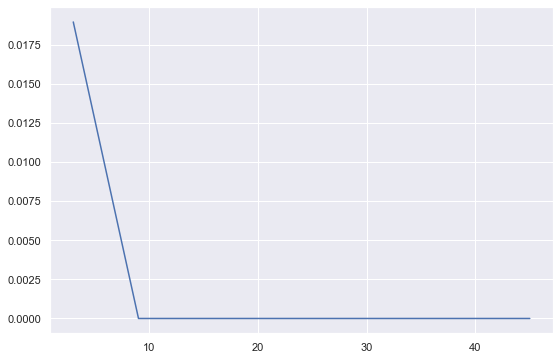

In [17]:
#plt.plot(num_experts, [data[ne]["prob_maj_correct"] for ne in num_experts], label="Prob M Correct")
plt.plot(num_experts, [data[ne]["prob_consensus_correct"] for ne in num_experts], label="Prob D Correct")